## Import Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

mushroom_data = pd.read_csv("./data/mushrooms.csv")


## Look at Data

The data I am using can be found on Kaggle here: https://www.kaggle.com/datasets/uciml/mushroom-classification. It gives various description variables about mushrooms and as well as a variable specifying if the mushroom is poisonous. I plan to use this data to train a model to predict if a mushroom is poisonous based on its properties. 



In [2]:
mushroom_data.head()


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


a


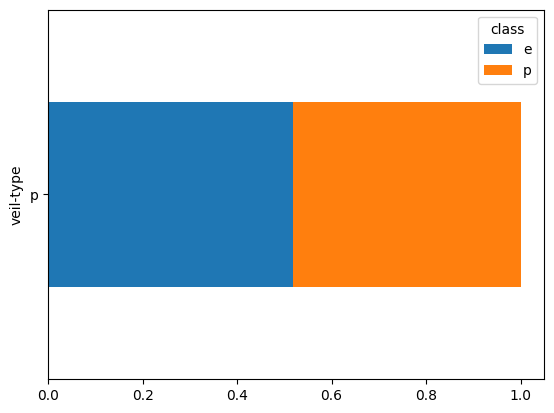

In [3]:
    
features = mushroom_data.columns.tolist()
features.pop(0)

cross_table = pd.crosstab(mushroom_data["veil-type"], mushroom_data["class"], normalize="index").sort_values(by="e")
cross_table.plot(kind="barh", stacked=True)

print("a")

## Unnecessary Variable

The variable `veil-type` has only 1 value so I will remove it.


In [4]:
features.remove("veil-type")


## Pipeline

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

def get_pipeline(X, model):
    cat_features = X.columns
    oh_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    preprocessor = ColumnTransformer(transformers=[
        ("cat_encoder", oh_encoder, cat_features)
    ]).set_output(transform="pandas")
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    return pipeline



## Split data 

I am encoding the target to be if the mushroom is edible. I then encode the features and split the data. 


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

pd.set_option('future.no_silent_downcasting', True)
y = mushroom_data["class"].replace(["e", "p"], [1, 0]).astype(int)

X_train, X_val, y_train, y_val = train_test_split(mushroom_data[features], y, random_state=123)



## Train Model

I am creating a decision tree classifier and fitting it to the training data. When testing the model with the testing data, I got an f1 score of 1, which is perfect.

In [7]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=10, random_state=123)

my_pipeline = get_pipeline(X_train, model)

my_pipeline.fit(X_train, y_train)

predictions = my_pipeline.predict(X_val)

print(f1_score(predictions, y_val))


1.0


## Feature Importances

Maybe some of these features are not necessary for the model to still perform well. Looking at the importances of each category I can see what features factor into decisions. The most important of these are odor, stalk-root, spore-print-color, ring-type, stalk-surface-below-ring.

In [8]:
importances = my_pipeline.named_steps["model"].feature_importances_
feature_names = my_pipeline.named_steps["preprocessor"].get_feature_names_out()

feature_scores = pd.DataFrame({"feature": feature_names, "importance": importances})
important_scores = feature_scores.sort_values(by="importance", ascending=False).loc[feature_scores["importance"] > 0]
print(important_scores)


                                     feature  importance
27                       cat_encoder__odor_n    0.624073
53                 cat_encoder__stalk-root_c    0.177612
55                 cat_encoder__stalk-root_r    0.081939
99          cat_encoder__spore-print-color_r    0.031457
22                       cat_encoder__odor_a    0.026492
25                       cat_encoder__odor_l    0.024641
93                  cat_encoder__ring-type_p    0.013661
63   cat_encoder__stalk-surface-below-ring_y    0.012041
108                cat_encoder__population_y    0.005459
7                 cat_encoder__cap-surface_g    0.001311
21                    cat_encoder__bruises_t    0.001296
35                  cat_encoder__gill-size_b    0.000018


As we can see from this plot, odor is a good predictor of whether a mushroom is edible or not. 

<Axes: ylabel='odor'>

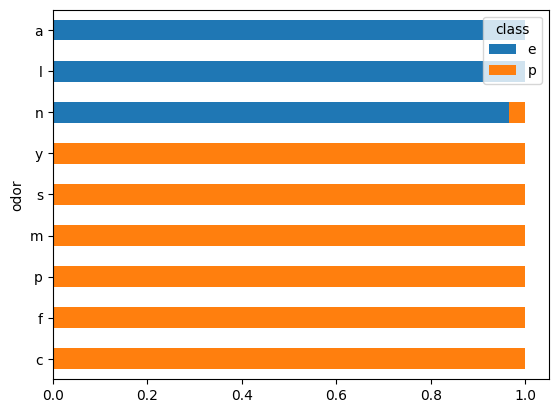

In [9]:
cross_table = pd.crosstab(mushroom_data["odor"], mushroom_data["class"], normalize="index").sort_values(by="e")
cross_table.plot(kind="barh", stacked=True)


## Minimal Features

Using only the top 3 most important features, I am able to create a model with an f1 score of 0.993 which is almost perfect. 

In [10]:
important_features =  ["odor", "stalk-root", "spore-print-color"]
X_train, X_val, y_train, y_val = train_test_split(mushroom_data[important_features], y, random_state=123)

my_pipeline = get_pipeline(X_train, model)
my_pipeline.fit(X_train, y_train)

predictions = my_pipeline.predict(X_val)
print(f1_score(predictions, y_val))


0.993032977241059


## More Features 

For a model predicting something that could be important like if a mushroom is edible or poisonous I might want the best model I can get. For this model I will use all features which are important. 

In [11]:
important_features =  ["odor", "stalk-root", "spore-print-color", "ring-type", 
                       "stalk-surface-below-ring", "population", "cap-surface", "bruises", "gill-size"]
X_train, X_val, y_train, y_val = train_test_split(mushroom_data[important_features], y, random_state=123)

my_pipeline = get_pipeline(X_train, model)
my_pipeline.fit(X_train, y_train)

predictions = my_pipeline.predict(X_val)
print(f1_score(predictions, y_val))

1.0


## Fitting All Data

Fitting all data and looking at importances. 

In [12]:

my_pipeline = get_pipeline(mushroom_data[important_features], model)
my_pipeline.fit(mushroom_data[important_features], y)

importances = my_pipeline.named_steps["model"].feature_importances_
feature_names = my_pipeline.named_steps["preprocessor"].get_feature_names_out()

feature_scores = pd.DataFrame({"feature": feature_names, "importance": importances})
important_scores = feature_scores.sort_values(by="importance", ascending=False).loc[feature_scores["importance"] > 0]
print(important_scores)


                                    feature  importance
5                       cat_encoder__odor_n    0.617099
11                cat_encoder__stalk-root_c    0.177286
13                cat_encoder__stalk-root_r    0.085734
19         cat_encoder__spore-print-color_r    0.033813
0                       cat_encoder__odor_a    0.023366
3                       cat_encoder__odor_l    0.022784
21         cat_encoder__spore-print-color_w    0.016582
31  cat_encoder__stalk-surface-below-ring_y    0.013766
27                 cat_encoder__ring-type_p    0.005634
39               cat_encoder__cap-surface_g    0.001965
33                cat_encoder__population_c    0.001932
44                 cat_encoder__gill-size_b    0.000038
